In [0]:
from os import listdir
import networkx as nx
import numpy as np
import pandas as pd
import operator
import collections
import math
import matplotlib.pyplot as plt
import community
from scipy.cluster.hierarchy import dendrogram, linkage
import plotly.plotly as py
import plotly.figure_factory as ff
import sys

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
path = '/content/gdrive/My Drive/School/HKUST/MSBD 5008/Project/youtube-video-080727'

In [0]:
headers = ['video_ID', 'uploader', 'age', 'category', 'length', 'views', 'rate', 'ratings', 
           'comments', "related_ID_0", "related_ID_1", "related_ID_2", "related_ID_3", 
           "related_ID_4", "related_ID_5", "related_ID_6", "related_ID_7", "related_ID_8", 
           "related_ID_9", "related_ID_10", "related_ID_11", "related_ID_12", "related_ID_13", 
           "related_ID_14", "related_ID_15", "related_ID_16", "related_ID_17", "related_ID_18", "related_ID_19"]

def sanitize(col):
    return col.str.strip()

def combine_related(col):
    return col.dropna().astype(str).values.tolist()

def process_file(filename):
    df = pd.read_csv(filename, sep='\t', header=None, names=headers, engine='python', error_bad_lines=False)

    if len(df.columns) < 29:
        raise Exception('Too few columns in file {0}'.format(filename))

    # combine the last 20 columns into a single one
    related = df.iloc[:,9:]
    dfmain = df.iloc[:,:9]
    
    strings = dfmain.select_dtypes(include='object').apply(axis=1, func=sanitize)
    numbers = dfmain.select_dtypes(include='number')

    df = pd.concat([strings, numbers], axis=1)
    df["related_IDs"]= related.apply(axis=1, func=combine_related)
    df['category'] = df['category'].astype('category')

    return df

def process_files(files):
    df = pd.DataFrame()

    for f in files:
        df = pd.concat([df, process_file(f)], axis=0)
    return df

def toEdgelist(dataframe):
    el = dataframe[['video_ID', 'related_IDs']]
    df = el['related_IDs'].apply(lambda x: pd.Series(x)).stack()    \
        .reset_index(level=1, drop=True).to_frame('related_ID')     \
        .join(el[['video_ID']], how='left')
    df.columns = ['dst', 'src']
    return df

In [0]:
df = process_files([path + '/youtube-video-0.txt', path + '/youtube-video-1.txt', path + '/youtube-video-2.txt']) # path + '/youtube-video-3.txt'])
#df2 = process_files(['./youtube-video-0.txt', './youtube-video-1.txt', './youtube-video-2.txt'])
#df3 = process_files(['./youtube-video-0.txt', './youtube-video-1.txt'])
print(df.shape)

# Filter out videos without related IDs. This happens because data collection uses BFS and videos at the last layer end up without related IDs.
df = df[df['related_IDs'].apply(lambda x: len(x)==0) == False]
print(df.shape)
df.head()

(11843, 10)
(7104, 10)


,video_ID,uploader,category,age,length,views,rate,ratings,comments,related_IDs
0,ly0dBk7yqYU,smosh,Comedy,1257.0,364.0,415091.0,4.77,10505.0,12464.0,"[MV95TjaXkX8, vVhSDhDOHh0, jfACnjzXc3o, gkVTdV..."
1,AknyR-kRvLc,JamesNintendoNerd,Comedy,1256.0,639.0,133590.0,4.89,4159.0,2600.0,"[rmeMGbJvu9E, aeGBf5lnhhY, vYVGslS0itE, JILwrJ..."
2,49hC9TpP_rY,JohnMcCaindotcom,News & Politics,1257.0,33.0,267795.0,2.38,1017.0,1700.0,"[mm9IUfPZsX8, Au0eBx05Zxc, 4yU2-LTFLf0, Z0cNqt..."
3,n7Oxb5kaBBE,charlieissocoollike,People & Blogs,1257.0,175.0,46592.0,4.88,1333.0,1606.0,"[9_u-sWwyWI8, T6jPQ6Ftesg, rEycXsyVu_U, SQ_HHV..."
4,sb3JbXuTkE8,makemebad35,Entertainment,1258.0,136.0,10367.0,4.86,1381.0,1580.0,"[v924OISPPpY, Bhi-Dv1ou6s, ETg3OZaTjWA, vHlLnJ..."


In [0]:
half = toEdgelist(df)
#G = nx.from_pandas_edgelist(half, source='src', target='dst', create_using=nx.Graph)
G = nx.from_pandas_edgelist(half, source='src', target='dst')

print(G.number_of_nodes())
print(G.number_of_edges())

85653
167773


In [0]:
D_nodes = nx.algorithms.dominating.dominating_set(G) 

In [0]:
# Girvan Newman
comp = nx.algorithms.community.centrality.girvan_newman(G)

def calculate_modularity(G, components):
    Q = modularity = 0
    M = 2.0 * G.number_of_edges()
    for component in components:
        for i in range(len(component)):
            for j in range(len(component)):
                if G.has_edge(component[i], component[j]):
                    modularity = 1
                else:
                    modularity = 0
                modularity -= (G.degree(component[i]) *
                               G.degree(component[j]) / M)
                Q += modularity
    return Q / M

In [0]:
max_modularity = -sys.maxsize
optimal_structure = None
for c in next(comp):
  modularity = calculate_modularity(G, c)
  if max_modularity < modularity:
    max_modularity = modularity
    optimal_structure = components
  print(f'{len(c)} clusters: modularity {modularity}')
print(f'optimal structure: {optimal_structure}')

In [0]:
dendro = community.generate_dendrogram(G)

In [0]:
def paris(G, copy_graph = True):
    n = G.number_of_nodes()
    if copy_graph:
        F = G.copy()
    else:
        F = G
        
    # index nodes from 0 to n - 1
    if set(F.nodes()) != set(range(n)):
        F = nx.convert_node_labels_to_integers(F)
        
    # node weights
    w = {u: 0 for u in range(n)}
    wtot = 0
    for (u,v) in F.edges():
        if 'weight' not in F[u][v]:
            F[u][v]['weight'] = 1
        weight = F[u][v]['weight']
        w[u] += weight
        w[v] += weight
        wtot += weight
        if u != v:
            wtot += weight

    # cluster sizes
    s = {u: 1 for u in range(n)}
    
    # connected components
    cc = []
        
    # dendrogram as list of merges
    D = []
    
    # cluster index
    u = n 
    while n > 0:
        # nearest-neighbor chain
        chain = [list(F.nodes())[0]]
        while chain != []:
            a = chain.pop()
            # nearest neighbor 
            dmin = float("inf")
            b = -1
            for v in F.neighbors(a):
                if v != a:
                    d = w[v] * w[a] / float(F[a][v]['weight']) / float(wtot)
                    if d < dmin:
                        b = v
                        dmin = d
                    elif d == dmin:
                        b = min(b,v)
            d = dmin
            if chain != []:
                c = chain.pop()
                if b == c:
                    # merge a,b
                    D.append([a,b,d,s[a] + s[b]])
                    # update graph
                    F.add_node(u)
                    neighbors_a = list(F.neighbors(a))
                    neighbors_b = list(F.neighbors(b))
                    for v in neighbors_a:
                        F.add_edge(u,v,weight = F[a][v]['weight'])
                    for v in neighbors_b:
                        if F.has_edge(u,v):
                            F[u][v]['weight'] += F[b][v]['weight']
                        else:
                            F.add_edge(u,v,weight = F[b][v]['weight'])
                    F.remove_node(a)
                    F.remove_node(b)
                    n -= 1
                    # update weight and size
                    w[u] = w.pop(a) + w.pop(b)
                    s[u] = s.pop(a) + s.pop(b)
                    # change cluster index
                    u += 1
                else:
                    chain.append(c)
                    chain.append(a)
                    chain.append(b)
            elif b >= 0:
                chain.append(a)
                chain.append(b)   
            else:
                # remove the connected component
                cc.append((a,s[a]))
                F.remove_node(a)
                w.pop(a)
                s.pop(a)
                n -= 1
    
    # add connected components to the dendrogram
    a,s = cc.pop()
    for b,t in cc:
        s += t
        D.append([a,b,float("inf"),s])
        a = u
        u += 1
        
    return reorder_dendrogram(np.array(D))

def reorder_dendrogram(D):
    n = np.shape(D)[0] + 1
    order = np.zeros((2,n - 1),float)
    order[0] = range(n - 1)
    order[1] = np.array(D)[:,2]
    index = np.lexsort(order)
    nindex = {i:i for i in range(n)}
    nindex.update({n + index[t]:n + t for t in range(n - 1)})
    return np.array([[nindex[int(D[t][0])],nindex[int(D[t][1])],D[t][2],D[t][3]] for t in range(n - 1)])[index,:]
  
def plot_dendrogram(D, logscale = True):
    plt.figure(figsize=(25, 10))
    Dlog = D.copy()
    if logscale:
        Dlog[:,2] = np.log(Dlog[:,2])
        Dlog[1:,2] =  Dlog[1:,2] - Dlog[1,2]
        Dlog[0,2] = 0
    dendrogram(Dlog,leaf_rotation=90.)
    plt.axis('off')
    plt.show()
    

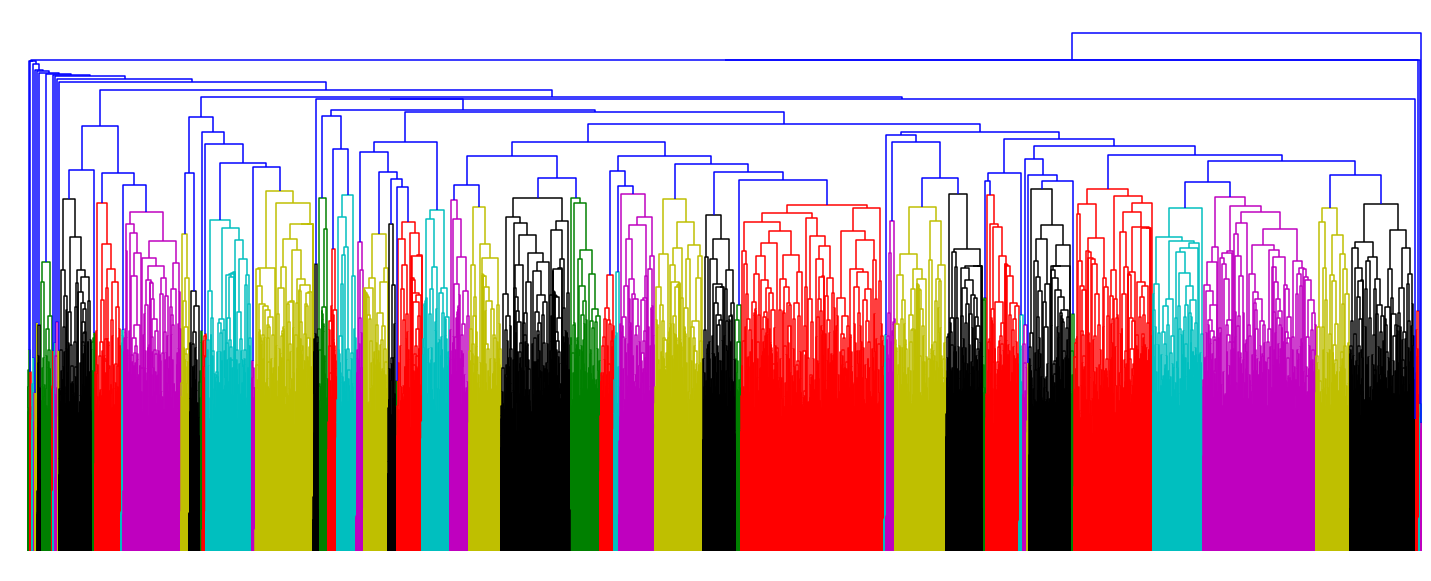

In [0]:
D = paris(G)
plot_dendrogram(D)

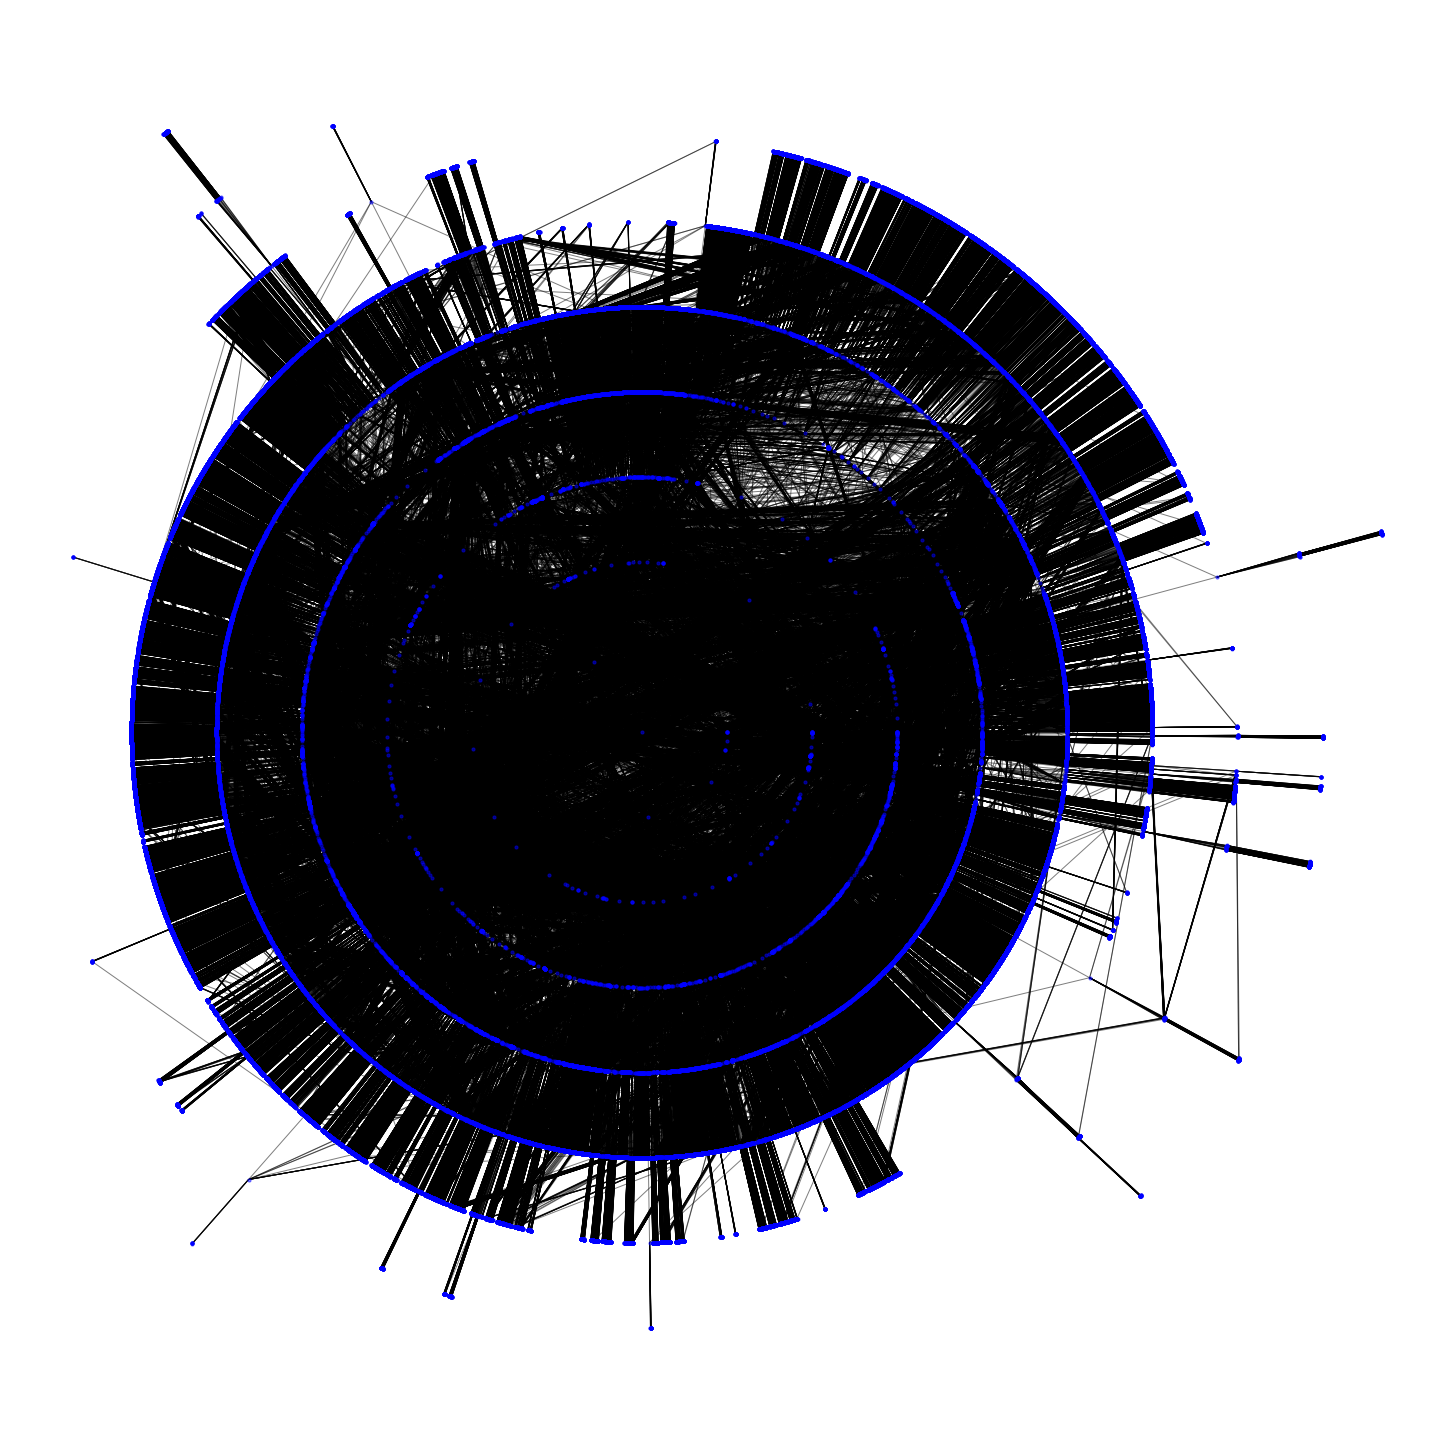

In [0]:
try:
    import pygraphviz
    from networkx.drawing.nx_agraph import graphviz_layout
except ImportError:
    try:
        import pydot
        from networkx.drawing.nx_pydot import graphviz_layout
    except ImportError:
        raise ImportError("This example needs Graphviz and either "
                          "PyGraphviz or pydot")

#G = nx.balanced_tree(3, 5)
pos = graphviz_layout(G, prog='twopi')
plt.figure(figsize=(20, 20))
nx.draw(G, pos, node_size=10, alpha=0.5, node_color="blue", with_labels=False)
plt.axis('equal')
plt.show()

In [0]:
for level in range(len(dendro) - 1):
  print("partition at level", level, "is", community.partition_at_level(dendro, level))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
G           = nx.from_pandas_edgelist(half, source='src', target='dst', create_using=nx.DiGraph)
nodes       = G.nodes()
leaves      = set( n for n in nodes if G.out_degree(n) == 0 )
inner_nodes = [ n for n in nodes if G.out_degree(n) > 0 ]

# Compute the size of each subtree
subtree = dict( (n, [n]) for n in leaves )
for u in inner_nodes:
    children = set()
    node_list = list(half[u])
    while len(node_list) > 0:
        v = node_list.pop(0)
        children.add( v )
        node_list += half[v]

    subtree[u] = sorted(children & leaves)

inner_nodes.sort(key=lambda n: len(subtree[n])) # <-- order inner nodes ascending by subtree size, root is last

# Construct the linkage matrix
leaves = sorted(leaves)
index  = dict( (tuple([n]), i) for i, n in enumerate(leaves) )
Z = []
k = len(leaves)
for i, n in enumerate(inner_nodes):
    children = half[n]
    x = children[0]
    for y in children[1:]:
        z = tuple(subtree[x] + subtree[y])
        i, j = index[tuple(subtree[x])], index[tuple(subtree[y])]
        Z.append([i, j, float(len(subtree[n])), len(z)]) # <-- float is required by the dendrogram function
        index[z] = k
        subtree[z] = list(z)
        x = z
        k += 1

# Visualize
dendrogram(Z, labels=leaves)
plt.show()

In [0]:
# Louvain
partition = community.best_partition(G)

#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))


nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

458


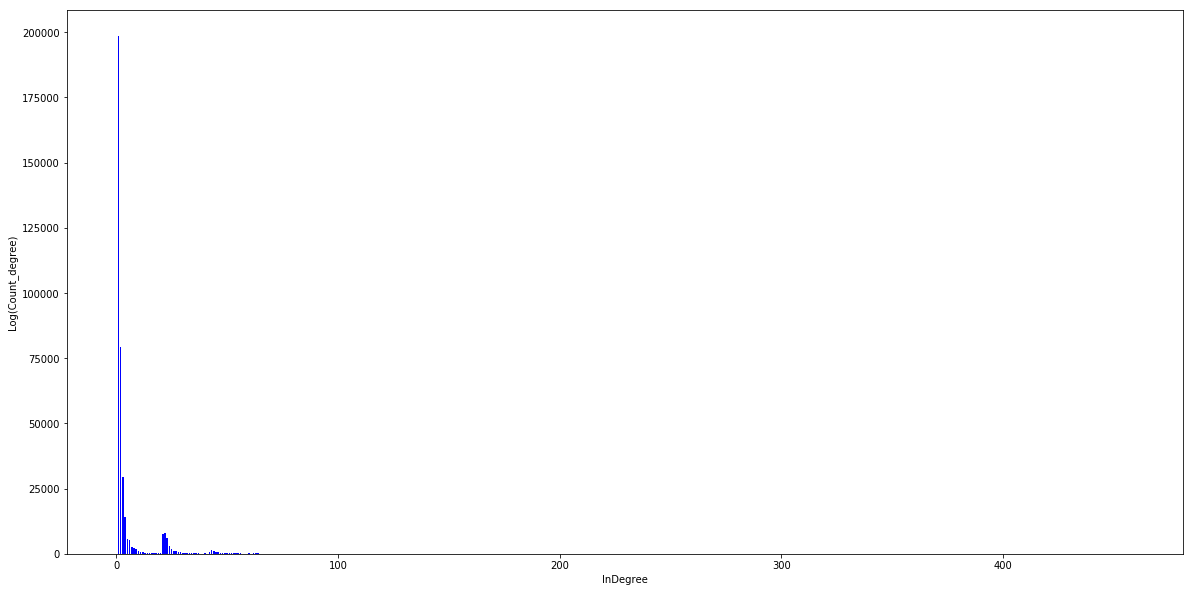

In [0]:
indg = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
print(indg[0])

# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(indg)
deg, cnt = zip(*degreeCount.items())
# logcnt = [math.log(v+1) for v in cnt]
plt.figure(figsize=(20, 10))
plt.bar(deg, cnt, width=0.70, color='b')
plt.xlabel('InDegree')
plt.ylabel('Log(Count_degree)')
plt.show()
#plt.savefig('indegree log_degree_count.png')